# MedDef 1.0: An Attention based Model for Adversarial Resilience in Medical Image Analysis

In [ ]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Add the current directory to the path for imports
sys.path.append(os.getcwd())

# Import our modules
from loader.dataset_handler import DatasetHandler
from loader.dataset_loader import DatasetLoader

# Load datasets
### Dataset Class




In [ ]:
# Set paths
DATA_PATH = Path("dataset")
OUTPUT_DIR = Path("processed_data")

In [ ]:
# # Configure plots
# plt.rcParams["figure.figsize"] = (12, 8)
# plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# Set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define helper functions for visualization
def show_batch(dataloader, title="Sample Images", max_images=16):
    # Get a batch from the dataloader
    images, labels = next(iter(dataloader))
    images = images[:max_images]
    labels = labels[:max_images]
    
    # Convert to grid
    grid = make_grid(images, nrow=4, normalize=True)
    
    # Plot the grid
    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=16)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    
    # Add class labels below
    class_names = dataloader.dataset.classes if hasattr(dataloader.dataset, 'classes') else [
        str(i) for i in range(len(images))]
    
    # For ImageFolder datasets accessed through DataLoader
    if hasattr(dataloader.dataset, 'dataset') and hasattr(dataloader.dataset.dataset, 'classes'):
        class_names = dataloader.dataset.dataset.classes
    
    plt.figure(figsize=(12, 3))
    for i in range(min(len(images), max_images)):
        plt.subplot(1, min(len(images), max_images), i+1)
        plt.text(0.5, 0.5, class_names[labels[i]], 
                 horizontalalignment='center', verticalalignment='center', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_class_distribution(dataloader, title="Class Distribution"):
    # Collect all labels from dataloader
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())
    
    # Convert to numpy array
    all_labels = np.array(all_labels)
    
    # Get class names
    class_names = dataloader.dataset.classes if hasattr(dataloader.dataset, 'classes') else [
        str(i) for i in range(len(np.unique(all_labels)))]
    
    # For ImageFolder datasets accessed through DataLoader
    if hasattr(dataloader.dataset, 'dataset') and hasattr(dataloader.dataset.dataset, 'classes'):
        class_names = dataloader.dataset.dataset.classes
    
    # Count class occurrences
    unique_classes, counts = np.unique(all_labels, return_counts=True)
    
    # Create DataFrame for easy plotting
    df = pd.DataFrame({
        'Class': [class_names[i] for i in unique_classes],
        'Count': counts
    })
    
    # Sort by count for better visualization
    df = df.sort_values('Count', ascending=False)
    
    # Plot
    plt.figure(figsize=(14, 6))
    plt.title(title, fontsize=16)
    ax = sns.barplot(x='Class', y='Count', data=df)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add count labels on top of bars
    for i, count in enumerate(df['Count']):
        ax.text(i, count + 5, str(count), ha='center')
    
    plt.show()

In [ ]:
def plot_image_properties(dataloader, title="Image Properties Distribution"):
    # Collect image properties
    dimensions = []
    channels = []
    
    for images, _ in dataloader:
        batch_size, n_channels, height, width = images.shape
        for i in range(batch_size):
            dimensions.append((height, width))
            channels.append(n_channels)
    
    # Convert to numpy arrays
    dimensions = np.array(dimensions)
    channels = np.array(channels)
    
    # Plot dimensions
    plt.figure(figsize=(14, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(1, 2, 1)
    plt.title("Image Dimensions")
    plt.scatter(dimensions[:, 1], dimensions[:, 0], alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.title("Channel Distribution")
    channel_counts = np.unique(channels, return_counts=True)
    plt.bar([f"{c} channels" for c in channel_counts[0]], channel_counts[1])
    plt.xlabel('Number of Channels')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_dataset_info(dataset_name):
    """Visualize dataset information by reading the dataset_info.txt file"""
    info_path = OUTPUT_DIR / dataset_name / 'dataset_info.txt'
    
    if not info_path.exists():
        print(f"No dataset info found at {info_path}")
        return
    
    # Read and display dataset info
    with open(info_path, 'r') as f:
        info_content = f.read()
    
    print(f"Dataset Information for {dataset_name}:")
    print("="*80)
    print(info_content)
    print("="*80)
    print("\n")

In [ ]:
def visualize_tsne(dataloader, title="t-SNE Visualization", n_samples=1000):
    """Visualize dataset using t-SNE dimensionality reduction"""
    # Collect samples and labels
    all_images = []
    all_labels = []
    for images, labels in dataloader:
        all_images.append(images)
        all_labels.append(labels)
        if len(all_images) * images.shape[0] >= n_samples:
            break
    
    # Convert to tensors
    all_images = torch.cat(all_images)[:n_samples]
    all_labels = torch.cat(all_labels)[:n_samples]
    
    # Flatten images
    flattened = all_images.view(all_images.shape[0], -1).numpy()
    
    # Apply PCA first to reduce dimensions (speed up t-SNE)
    print("Computing PCA...")
    pca = PCA(n_components=min(50, flattened.shape[1], flattened.shape[0]))
    reduced_data = pca.fit_transform(flattened)
    
    # Apply t-SNE
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    tsne_result = tsne.fit_transform(reduced_data)
    
    # Plot results
    plt.figure(figsize=(12, 10))
    plt.title(title, fontsize=16)
    
    # Get class names
    class_names = dataloader.dataset.classes if hasattr(dataloader.dataset, 'classes') else [
        str(i) for i in range(len(np.unique(all_labels)))]
    
    # For ImageFolder datasets accessed through DataLoader
    if hasattr(dataloader.dataset, 'dataset') and hasattr(dataloader.dataset.dataset, 'classes'):
        class_names = dataloader.dataset.dataset.classes
    
    # Plot each class with different color
    unique_labels = all_labels.unique().numpy()
    for label in unique_labels:
        idx = all_labels == label
        plt.scatter(
            tsne_result[idx, 0], 
            tsne_result[idx, 1], 
            label=class_names[label],
            alpha=0.6
        )
    
    plt.legend()
    plt.show()


In [20]:
# Understanding the dataset

def display_image(image, title, ax, dataset_name=None):
    if image is None:
        raise ValueError("Input image is None.")
    if not isinstance(image, (np.ndarray, torch.Tensor, np.memmap)):
        raise TypeError("Unsupported image type. Must be np.ndarray, torch.Tensor, or np.memmap.")

    print(f"Initial image type: {type(image)}, shape: {image.shape}")

    if isinstance(image, np.memmap):
        image = np.array(image)
        print(f"Converted from memmap to ndarray, shape: {image.shape}")

    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()
        print(f"Converted from tensor to ndarray, shape: {image.shape}")

    if image.ndim not in [2, 3, 4]:
        raise ValueError(f"Unsupported image dimensions: {image.ndim}. Expected 2D, 3D, or 4D image.")

    if image.ndim == 4:
        image = image[:, :, :, image.shape[3] // 2]
        print(f"Selected middle slice for 4D image, new shape: {image.shape}")

    if image.ndim == 3:
        if image.shape[0] in [1, 3]:
            image = np.transpose(image, (1, 2, 0))
            print(f"Transposed 3D image to (H, W, C), new shape: {image.shape}")

    if image.ndim == 3 and image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)
        print(f"Squeezed single-channel image, new shape: {image.shape}")

    if image.dtype == np.float32 or image.max() <= 1.0:
        image = np.clip(image * 255, 0, 255).astype(np.uint8)
        print(f"Scaled image to 0-255 range, dtype: {image.dtype}")

    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
        print(f"Converted 2D grayscale image to 3D RGB, new shape: {image.shape}")

    try:
        pil_image = Image.fromarray(image.astype(np.uint8))
        print(f"Converted image to PIL format, mode: {pil_image.mode}")
    except Exception as e:
        raise ValueError(f"Error converting image to PIL format: {e}")

    ax.imshow(pil_image, cmap='gray' if pil_image.mode == 'L' else None)
    ax.set_title(title)
    ax.axis('off')

def print_dataset_heads(datasets, num_samples=5):
    for dataset_name, dataset_loader in datasets.items():
        try:
            print(f"Displaying head for dataset: {dataset_name}")
            train_loader, val_loader, test_loader = dataset_loader.load()
            
            # Display samples from the training set
            print(f"\nDataset: {dataset_name} - Training Set")
            fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
            for i, (image, label) in enumerate(train_loader):
                if i >= num_samples:
                    break
                display_image(image, f"Train Sample {i+1} - Label: {label}", axes[i], dataset_name=dataset_name)
            plt.show()

        except Exception as e:
            print(f"Error displaying head for dataset {dataset_name}: {e}")

In [ ]:
# Function to analyze and visualize a dataset
def analyze_dataset(dataset_name):
    print(f"\n{'='*80}")
    print(f"Analyzing Dataset: {dataset_name}")
    print(f"{'='*80}")
    
    # Display dataset info from txt file
    visualize_dataset_info(dataset_name)
    
    try:
        # Method 1: Using DatasetLoader (your original class)
        loader = DatasetLoader()
        batch_size = {'train': 32, 'val': 32, 'test': 32}
        train_loader, val_loader, test_loader = loader.load_data(dataset_name, batch_size)
        
        print(f"Successfully loaded {dataset_name} using DatasetLoader")
        print(f"Train samples: {len(train_loader.dataset)}")
        print(f"Validation samples: {len(val_loader.dataset)}")
        print(f"Test samples: {len(test_loader.dataset)}")
        print(f"Classes: {train_loader.dataset.classes}")
        print("\n")
        
    except Exception as e:
        print(f"Error with DatasetLoader: {str(e)}")
        print("Trying with DatasetHandler instead...")
        
        try:
            # Method 2: Using DatasetHandler
            handler = DatasetHandler(dataset_name)
            train_loader, val_loader, test_loader = handler.process_and_load(
                OUTPUT_DIR,
                train_batch_size=32,
                val_batch_size=32,
                test_batch_size=32
            )
            
            print(f"Successfully loaded {dataset_name} using DatasetHandler")
            print(f"Train samples: {len(train_loader.dataset)}")
            print(f"Validation samples: {len(val_loader.dataset)}")
            print(f"Test samples: {len(test_loader.dataset)}")
            print("\n")
            
        except Exception as e2:
            print(f"Error with DatasetHandler: {str(e2)}")
            print("Both loading methods failed. Skipping dataset.")
            return
    
    # Visualize the dataset
    print("Showing sample images from training set...")
    show_batch(train_loader, title=f"{dataset_name} - Training Samples")
    
    print("Plotting class distribution...")
    plot_class_distribution(train_loader, title=f"{dataset_name} - Class Distribution")
    
    print("Analyzing image properties...")
    plot_image_properties(train_loader, title=f"{dataset_name} - Image Properties")
    
    print("Computing t-SNE visualization...")
    try:
        # Use a smaller dataloader for t-SNE to avoid memory issues
        small_loader = DataLoader(
            train_loader.dataset, 
            batch_size=64,
            shuffle=True,
            num_workers=0
        )
        visualize_tsne(small_loader, title=f"{dataset_name} - t-SNE Visualization", n_samples=500)
    except Exception as e:
        print(f"Error during t-SNE visualization: {str(e)}")
    
    print(f"Completed analysis of {dataset_name}")

In [21]:
# Check the head of each dataset
# Call the function to print the head of each dataset
print_dataset_heads()

TypeError: print_dataset_heads() missing 1 required positional argument: 'datasets'

Available datasets:
1. ccts
2. scisic
3. rotc
4. dermnet
5. chest_xray

Analyzing Dataset: ccts
Dataset Information for ccts:
Dataset: ccts

Original Image Properties:
  - Size: (409, 264)
  - Channels: 4 (R, G, B, A)

Target Processing Properties:
  - Shape: (4, 224, 224)
  - Channels: 4

Split Information:
--------------------

TRAIN:
Total images: 613
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 3 (R, G, B)
Class Distribution:
  - adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195 images
  - large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115 images
  - normal: 148 images
  - squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155 images

VAL:
Total images: 72
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 3 (R, G, B)
Class Distribution:
  - adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 23 images
  - large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 21 images
  - normal: 13 images
  - squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 15 image

<ipython-input-11-ccdf5c2f8155>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


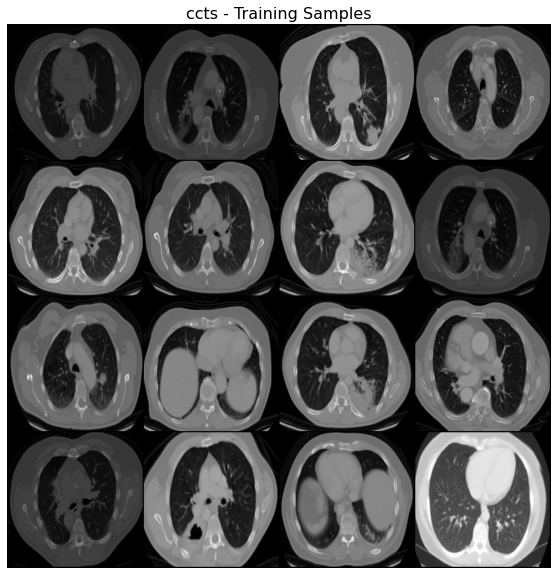

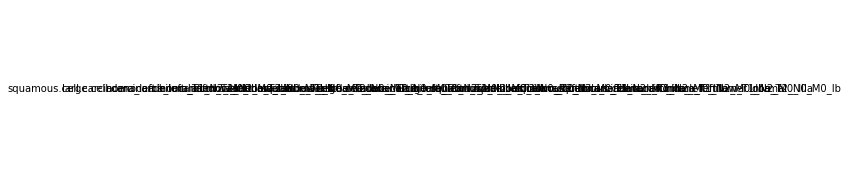

Plotting class distribution...


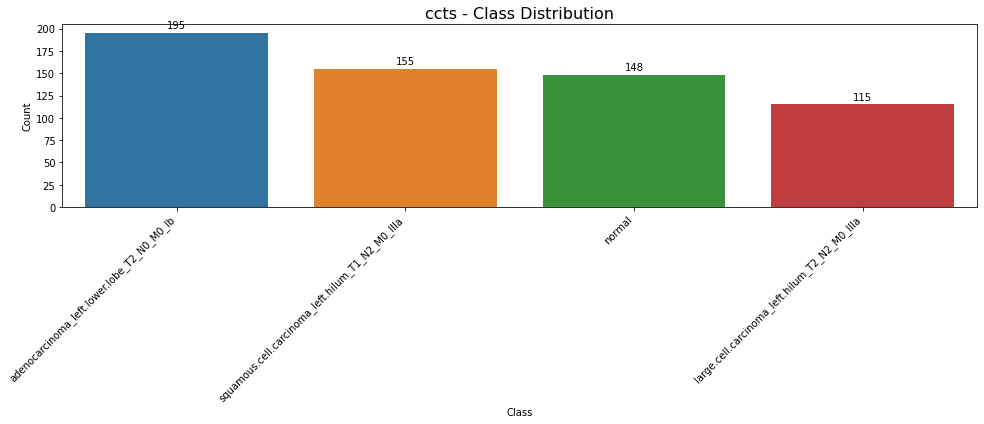

Analyzing image properties...


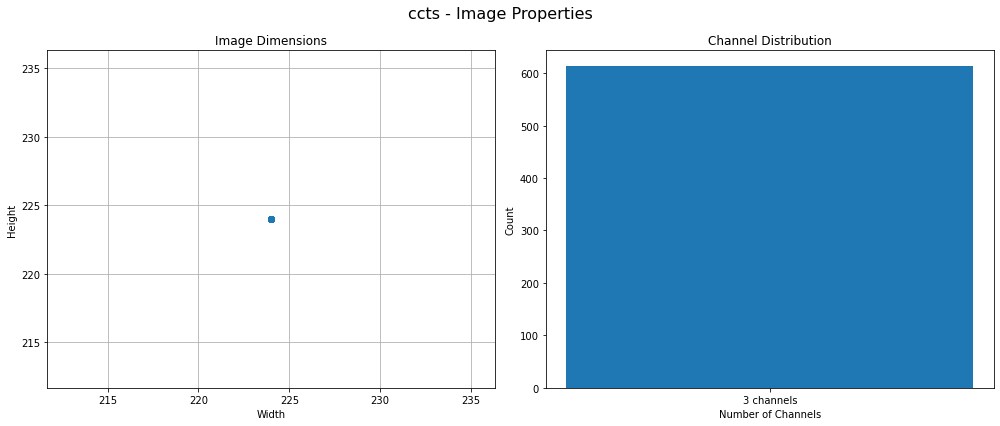

Computing t-SNE visualization...
Computing PCA...
Computing t-SNE...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feea4607940>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


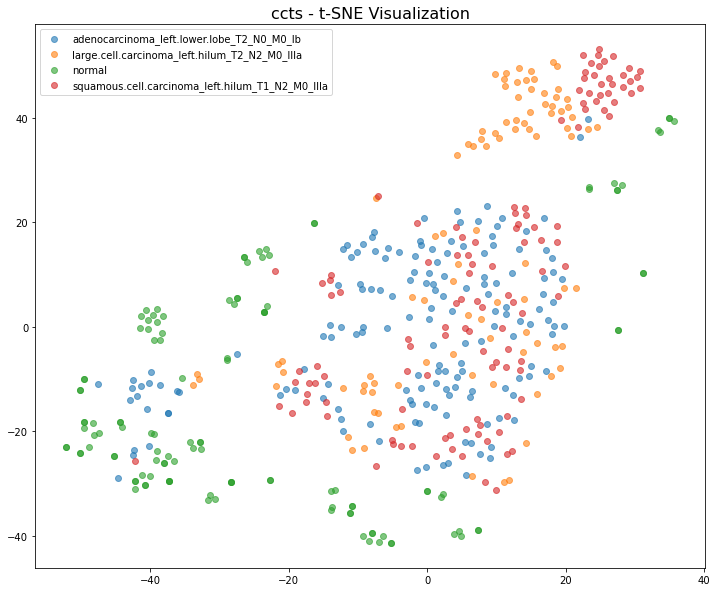

Completed analysis of ccts

Analyzing Dataset: scisic
Dataset Information for scisic:
Dataset: scisic

Original Image Properties:
  - Size: (600, 450)
  - Channels: 3 (R, G, B)

Target Processing Properties:
  - Shape: (3, 224, 224)
  - Channels: 3

Split Information:
--------------------

TRAIN:
Total images: 1898
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 3 (R, G, B)
Class Distribution:
  - actinic keratosis: 96 images
  - basal cell carcinoma: 319 images
  - dermatofibroma: 80 images
  - melanoma: 372 images
  - nevus: 303 images
  - pigmented benign keratosis: 392 images
  - seborrheic keratosis: 65 images
  - squamous cell carcinoma: 153 images
  - vascular lesion: 118 images

VAL:
Total images: 341
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 3 (R, G, B)
Class Distribution:
  - actinic keratosis: 18 images
  - basal cell carcinoma: 57 images
  - dermatofibroma: 15 images
  - melanoma: 66 images
  - nevus: 54 images
  - pigme

<ipython-input-11-ccdf5c2f8155>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


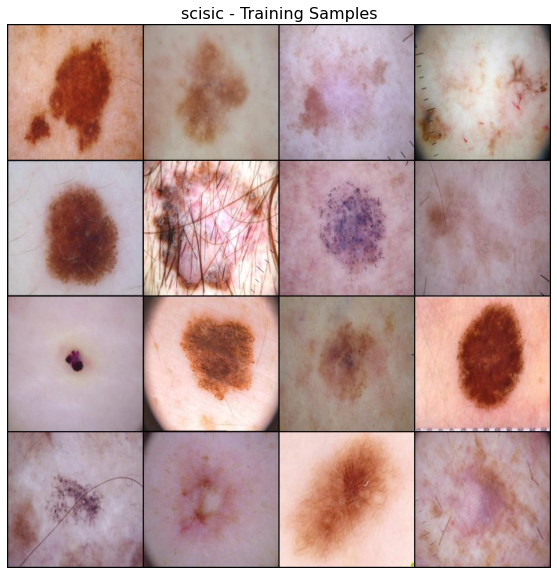

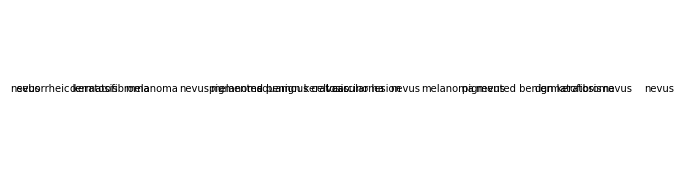

Plotting class distribution...


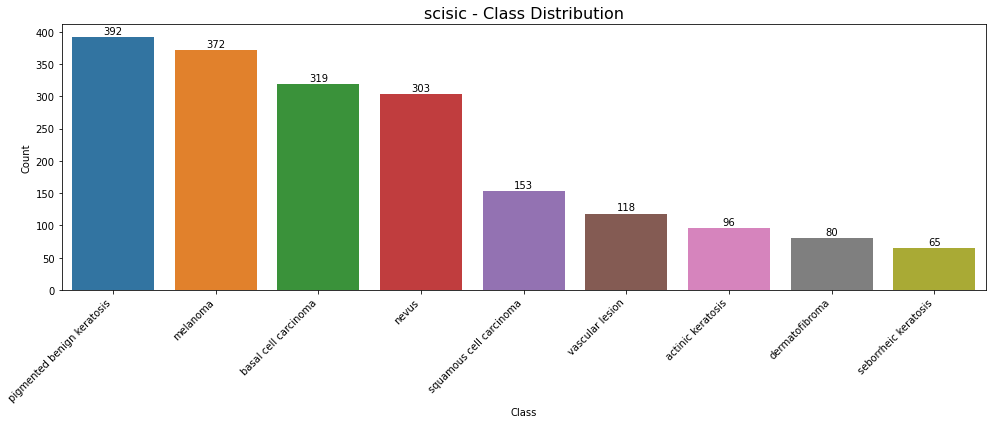

Analyzing image properties...


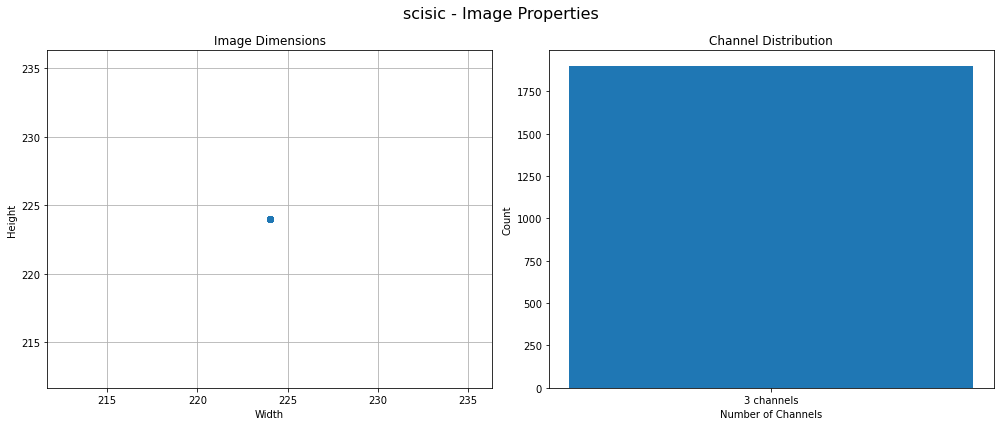

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fed812f5790>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


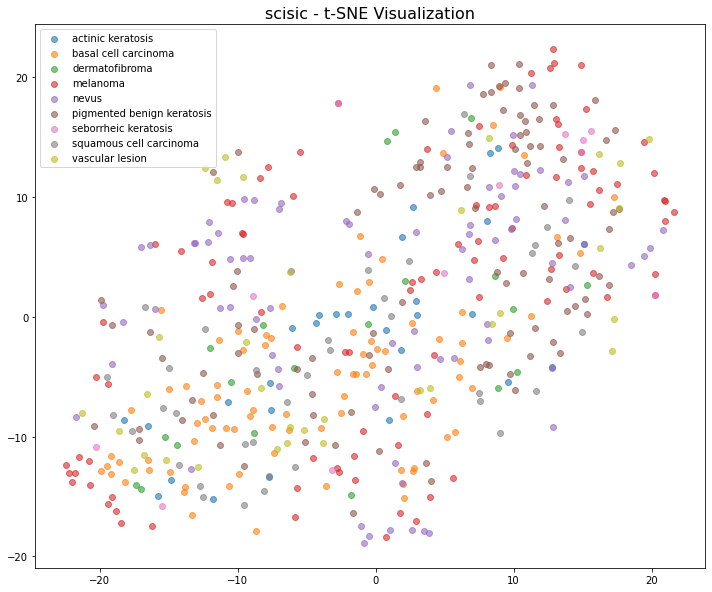

Completed analysis of scisic

Analyzing Dataset: rotc
Dataset Information for rotc:
Dataset: rotc

Original Image Properties:
  - Size: (512, 496)
  - Channels: 1 (L)

Target Processing Properties:
  - Shape: (1, 224, 224)
  - Channels: 1

Split Information:
--------------------

TRAIN:
Total images: 83484
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 3 (R, G, B)
Class Distribution:
  - CNV: 37205 images
  - DME: 11348 images
  - DRUSEN: 8616 images
  - NORMAL: 26315 images

VAL:
Total images: 32
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 3 (R, G, B)
Class Distribution:
  - CNV: 8 images
  - DME: 8 images
  - DRUSEN: 8 images
  - NORMAL: 8 images

TEST:
Total images: 968
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 3 (R, G, B)
Class Distribution:
  - CNV: 242 images
  - DME: 242 images
  - DRUSEN: 242 images
  - NORMAL: 242 images

Total Dataset Images: 84484

Preprocessing Information:
------------------

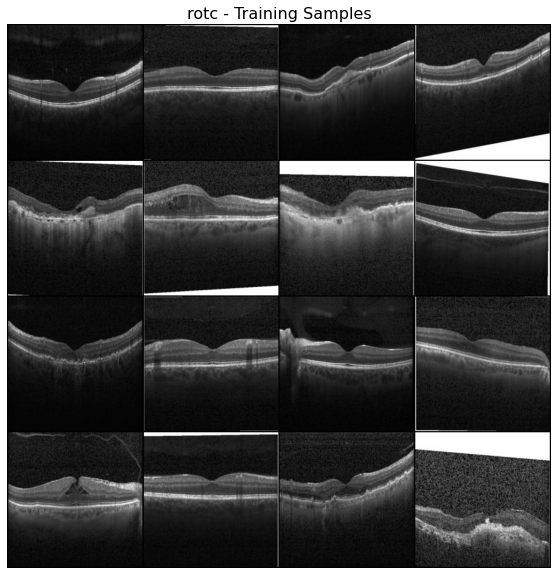

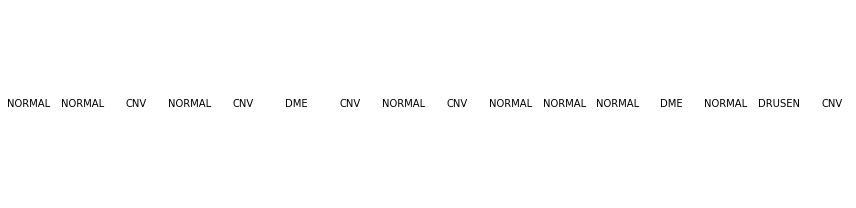

Plotting class distribution...


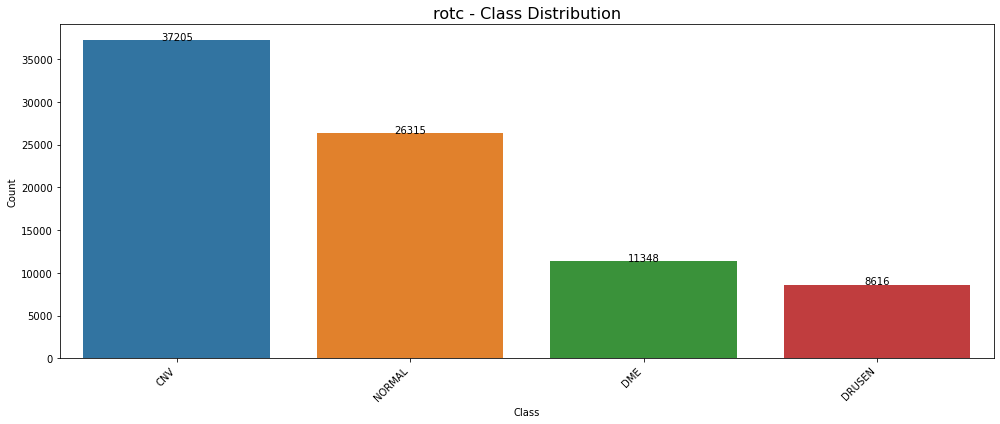

Analyzing image properties...


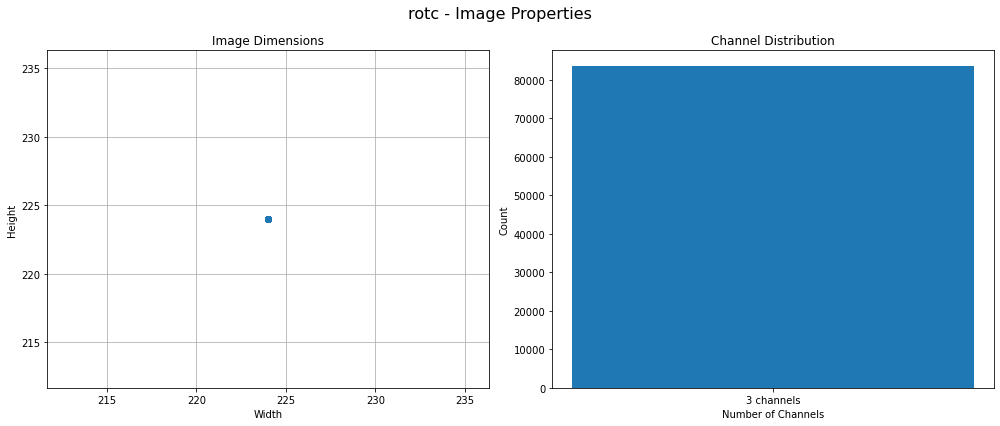

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fee995aff70>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


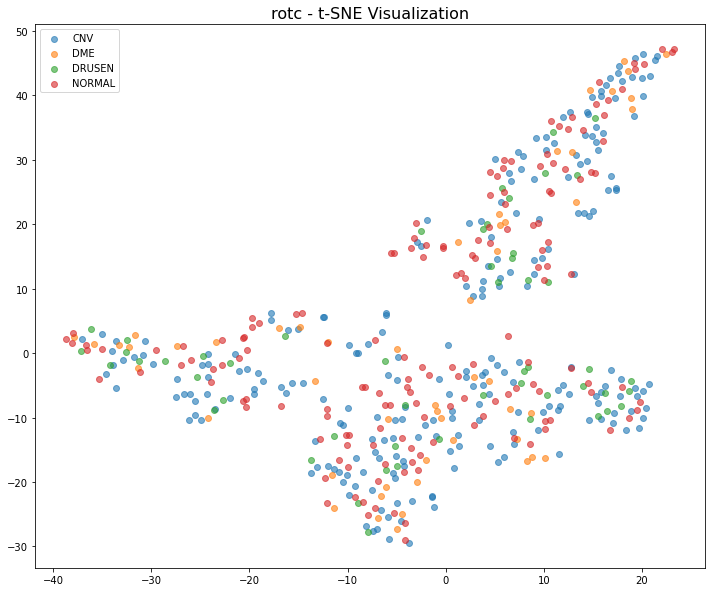

Completed analysis of rotc

Analyzing Dataset: dermnet
Dataset Information for dermnet:
Dataset: dermnet

Original Image Properties:
  - Size: (720, 472)
  - Channels: 3 (R, G, B)

Target Processing Properties:
  - Shape: (3, 224, 224)
  - Channels: 3

Split Information:
--------------------

TRAIN:
Total images: 13215
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 3 (R, G, B)
Class Distribution:
  - Acne and Rosacea Photos: 714 images
  - Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 976 images
  - Atopic Dermatitis Photos: 415 images
  - Bullous Disease Photos: 380 images
  - Cellulitis Impetigo and other Bacterial Infections: 244 images
  - Eczema Photos: 1049 images
  - Exanthems and Drug Eruptions: 343 images
  - Hair Loss Photos Alopecia and other Hair Diseases: 203 images
  - Herpes HPV and other STDs Photos: 344 images
  - Light Diseases and Disorders of Pigmentation: 482 images
  - Lupus and other Connective Tissue diseases: 357 i

<ipython-input-11-ccdf5c2f8155>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


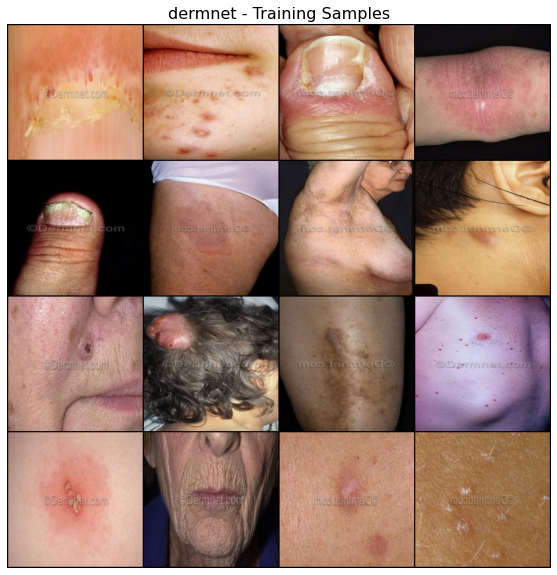

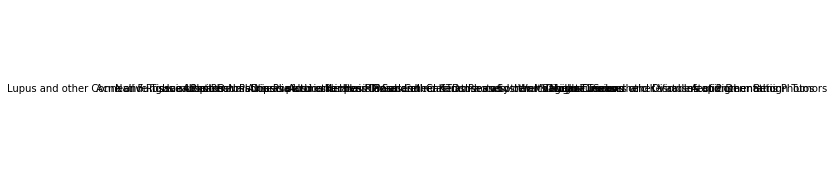

Plotting class distribution...


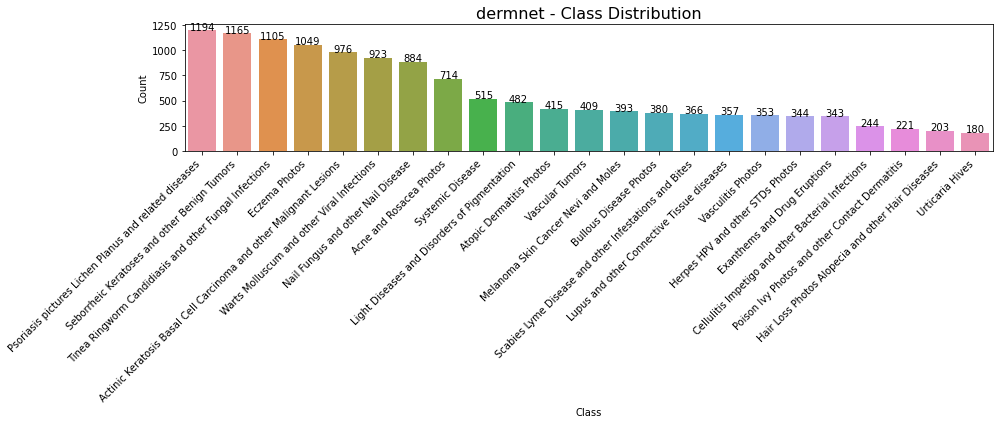

Analyzing image properties...


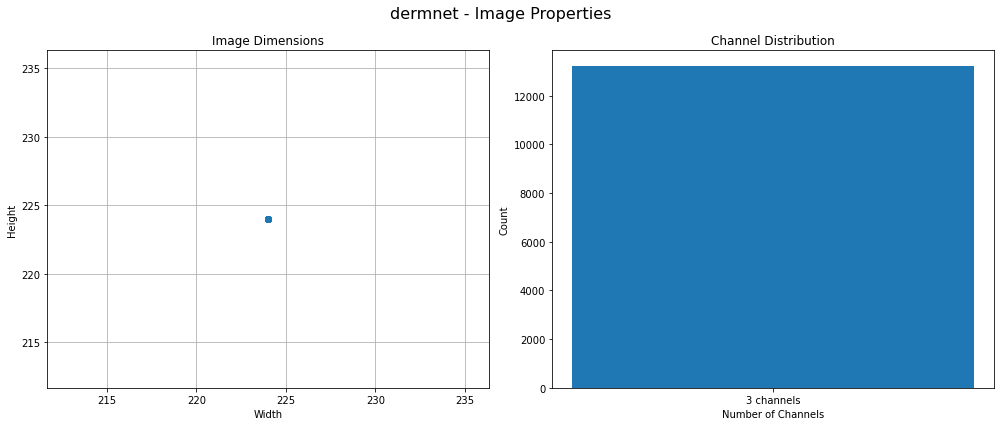

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feea48f9f70>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


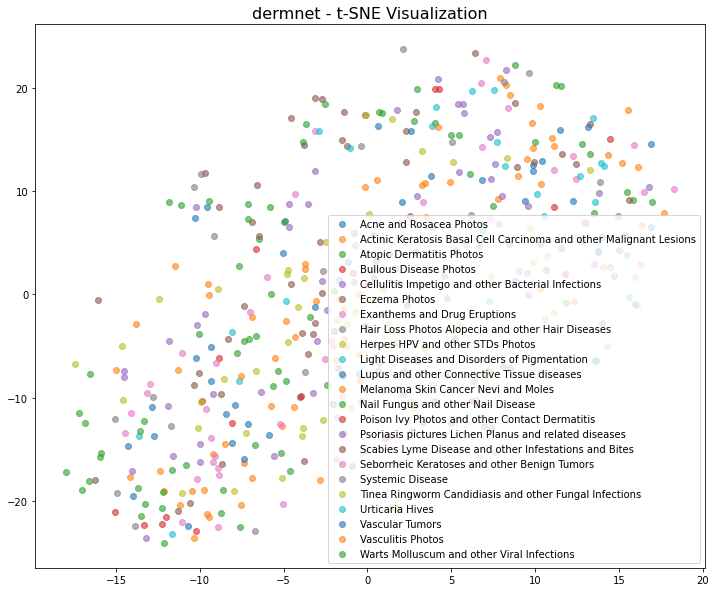

Completed analysis of dermnet

Analyzing Dataset: chest_xray
Dataset Information for chest_xray:
Dataset: chest_xray

Original Image Properties:
  - Size: (2090, 1858)
  - Channels: 1 (L)

Target Processing Properties:
  - Shape: (1, 224, 224)
  - Channels: 1

Split Information:
--------------------

TRAIN:
Total images: 5216
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 1 (L)
Class Distribution:
  - NORMAL: 1341 images
  - PNEUMONIA: 3875 images

VAL:
Total images: 16
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 1 (L)
Class Distribution:
  - NORMAL: 8 images
  - PNEUMONIA: 8 images

TEST:
Total images: 624
Classes:
Processed Image Properties:
  - Size: (224, 224)
  - Channels: 1 (L)
Class Distribution:
  - NORMAL: 234 images
  - PNEUMONIA: 390 images

Total Dataset Images: 5856

Preprocessing Information:
--------------------
Applied Preprocessing:
  - remove_noise: True



Successfully loaded chest_xray using DatasetLoader
Train sa

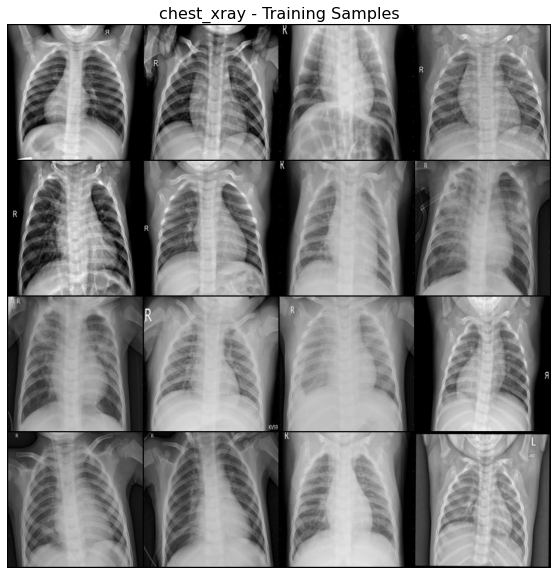

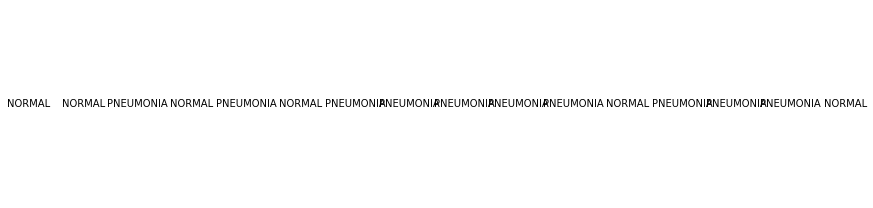

Plotting class distribution...


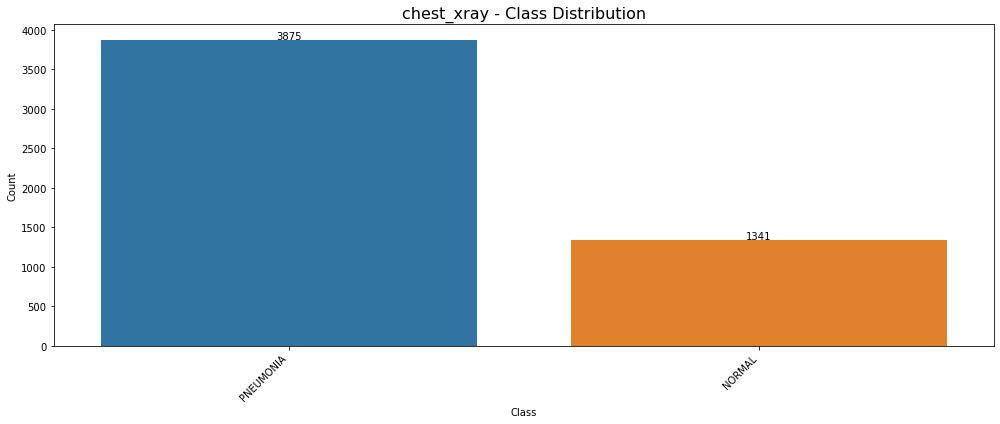

Analyzing image properties...


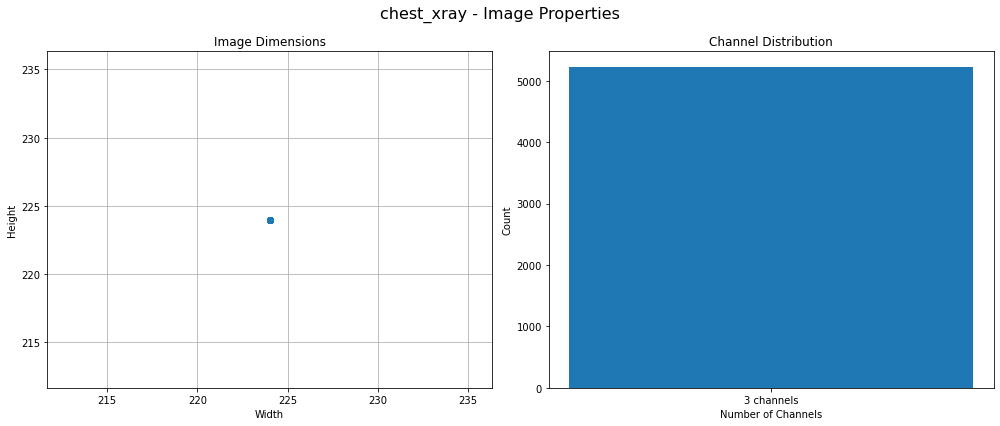

Computing t-SNE visualization...
Computing PCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7feea4748550>
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Computing t-SNE...


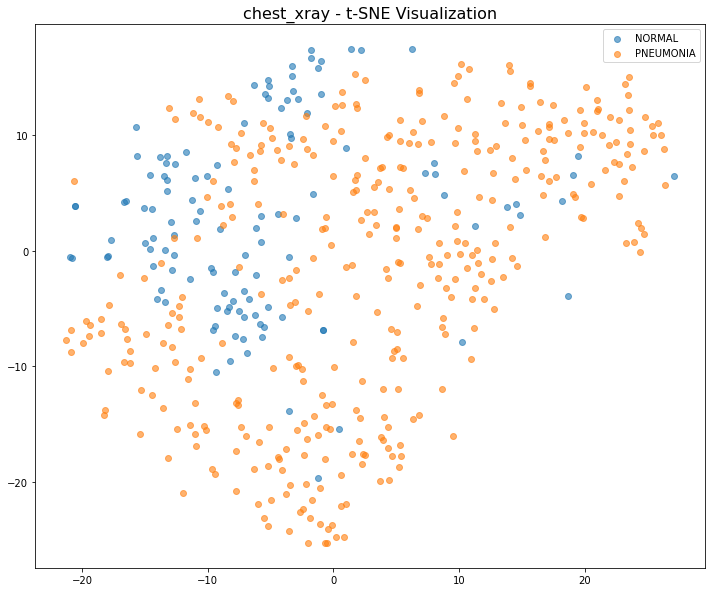

Completed analysis of chest_xray


In [ ]:
# Main execution block
if __name__ == "__main__":
    # List of datasets to analyze
    datasets = [
        'ccts', 
        'scisic', 
        'rotc', 
        # 'kvasir', 
        'dermnet',
        'chest_xray', 
        # 'tbcr', 
        # 'miccai_brats2020'
    ]
    
    # Allow user to select which datasets to analyze
    print("Available datasets:")
    for i, name in enumerate(datasets):
        print(f"{i+1}. {name}")
    
    selected = input("Enter dataset numbers to analyze (comma-separated), or 'all' for all datasets: ")
    
    if selected.lower() == 'all':
        selected_datasets = datasets
    else:
        indices = [int(idx.strip()) - 1 for idx in selected.split(",")]
        selected_datasets = [datasets[i] for i in indices if 0 <= i < len(datasets)]
    
    # Analyze each selected dataset
    for dataset_name in selected_datasets:
        analyze_dataset(dataset_name)

INFO:root:Displaying head for dataset: ccts
INFO:root:Loading dataset: ccts.



Dataset: ccts - Training Set
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D im

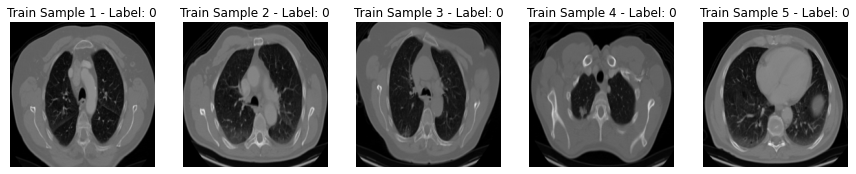

INFO:root:Displaying head for dataset: tbcr
INFO:root:Loading dataset: tbcr.



Dataset: tbcr - Training Set
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D im

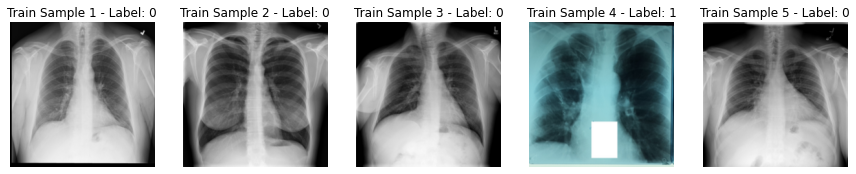

INFO:root:Displaying head for dataset: scisic
INFO:root:Loading dataset: scisic.



Dataset: scisic - Training Set
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D 

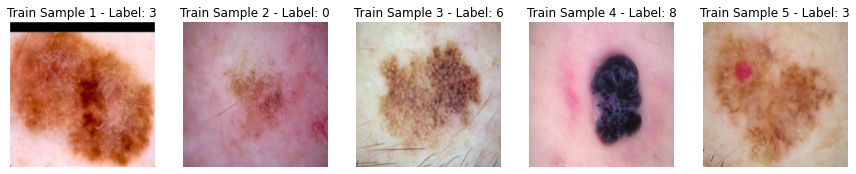

INFO:root:Displaying head for dataset: rotc
INFO:root:Loading dataset: rotc.



Dataset: rotc - Training Set
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D image to (H, W, C), new shape: (224, 224, 3)
Scaled image to 0-255 range, dtype: uint8
Converted image to PIL format, mode: RGB
Initial image type: <class 'torch.Tensor'>, shape: torch.Size([3, 224, 224])
Converted from tensor to ndarray, shape: (3, 224, 224)
Transposed 3D im

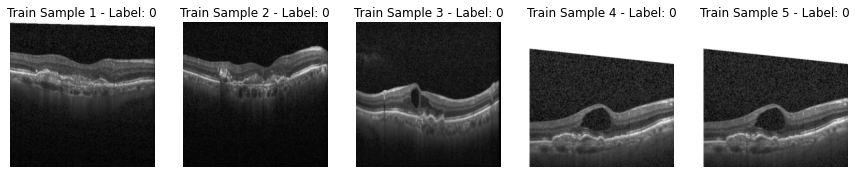

In [ ]:
def advanced_dataset_exploration(dataset_name):
    """Perform comprehensive dataset exploration with the new visualization tools"""
    print(f"\n{'='*80}")
    print(f"Advanced Exploration: {dataset_name}")
    print(f"{'='*80}")
    
    try:
        # Load dataset
        loader = DatasetLoader()
        batch_size = {'train': 32, 'val': 16, 'test': 16}
        train_loader, val_loader, test_loader = loader.load_data(dataset_name, batch_size)
        
        print(f"Successfully loaded {dataset_name}")
        print(f"Classes: {train_loader.dataset.classes}")
        print(f"Training samples: {len(train_loader.dataset)}")
        
        # Visualize samples with detailed display
        print("\nVisualizing dataset samples with intensity maps...")
        visualize_dataset_samples(train_loader, dataset_name, num_samples=5)
        
        # Analyze image characteristics
        print("\nAnalyzing image characteristics...")
        analyze_image_characteristics(dataset_name, batch_size)
        
        # Show class distribution
        print("\nClass distribution in training set:")
        plot_class_distribution(train_loader, title=f"{dataset_name} - Training Set Class Distribution")
        
        # Show class distribution in validation set
        print("\nClass distribution in validation set:")
        plot_class_distribution(val_loader, title=f"{dataset_name} - Validation Set Class Distribution")
        
    except Exception as e:
        print(f"Error during advanced exploration of {dataset_name}: {e}")
        import traceback
        traceback.print_exc()

# Example usage - uncomment to run exploration on specific datasets
# advanced_dataset_exploration('ccts')
# advanced_dataset_exploration('dermnet')